# Models training
In this notebook we train and analyze multiple models, compare them and tune them to get the best results. We will work with a small subset due to low hardware availability.

## 0.1 Load variable
This notebook is a direct continuation of data_preprocessing.ipynb. We start by loading the necessary libraries variables from that.

In [12]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from collections import Counter
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap


with open('landmarks_subset_proccessed.pkl', 'rb') as file:
    subset_landmarks = pickle.load(file)

data_info = pd.read_csv('video_labels.csv',dtype={'video_id': object})
subset_words = ['tall', 'man', 'red', 'shirt', 'play', 'basketball', 'cold', 'pizza', 'top', 'cheese', 'taste',
                'delicious', 'lazy', 'afternoon', 'dark', 'room', 'small', 'lamp', 'empty',
                'big', 'dog', 'walk', 'beautiful', 'every', 'morning', 'short',
                'woman', 'wear', 'dress', 'have', 'beautiful', 'daughter']


POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1
videos_per_word = Counter(data_info.loc[data_info.word.isin(subset_words),'word'])

In [16]:
def pick_frames(video, num_frames):
    step_size = len(video) // num_frames
    video_shorter = video[::step_size][:num_frames]
    return video_shorter

def pick_frames_for_all(videos):
    standard_videos = {}
    for x in videos:
        shorter = pick_frames(videos[x], 20)
        standard_videos[x] = shorter
    return standard_videos

standard_videos = pick_frames_for_all(subset_landmarks)

In [17]:
print(len(standard_videos))

274


In [5]:
train_signer_ids = [118, 31, 59, 11, 115, 94, 6, 21, 10, 38, 56, 41, 4, 45, 32, 46, 13,
                    42, 39, 17, 89, 60, 35, 15, 3, 92, 93, 34, 107, 28, 99, 37, 8, 97,
                    70, 19, 91, 106, 63, 29, 26, 117, 66, 119, 50, 103, 120, 95, 78, 27,
                    108, 57, 53, 75, 104, 43, 40, 77, 1, 33, 22, 105, 48, 73, 23]
val_signer_ids = [2, 52, 12, 98, 88]
test_signer_ids = [59, 115, 90, 4, 116, 100, 101, 102, 96, 90]

num_of_words = data_info[data_info["word"].isin(subset_words)]["word"].nunique()
subset_data = data_info[data_info["word"].isin(subset_words)]
subset_train_data = subset_data[subset_data["signer_id"].isin(train_signer_ids)]
subset_test_data = subset_data[subset_data["signer_id"].isin(val_signer_ids)]
subset_validation_data = subset_data[subset_data["signer_id"].isin(test_signer_ids)]

print(f"subset train data count: {len(subset_train_data)}")
print(f"subset test data count: {len(subset_test_data)}")
print(f"subset validation data count: {len(subset_validation_data)}")
print(f"num of words: {num_of_words}")

subset train data count: 202
subset test data count: 37
subset validation data count: 32
num of words: 31


# 1.0 Unsupervised - Base Model
We first try and distinguish the words without letting the model know the labels.



# 1.1 Dynamic Time Wrapping and KMeans (DTW)
Dynamic Time Wrapping can detect similar motions but its computation is slow, let's take videos of two words only, without the face (which has the majority of landmarks) and check whether it is a good approach.

We start with a sainity check for DTW. Just a few sample to keep computations reasonably quick.

In [25]:

#words = ["play","basketball","morning","tall","dress","beautiful"]
#words = ["short", "tall", "woman", "man","small", "big", "morning", "afternoon", ]
#for word in words:
    #print(word, videos_per_word[word])

dtw_landmarks = {}
for word in subset_train_data["word"].unique():
    videos = subset_train_data.loc[subset_train_data.word==word,'video_id']
    # Exclude augmented videos for now
    for vid in videos[:2]:
        dtw_landmarks[vid] = standard_videos[vid][:,POSE+LH+RH,:]
print(len(dtw_landmarks))
dtw_landmarks

62


{'62175': array([[[ 0.4445011 ,  0.21856713, -1.2212925 ],
         [ 0.46559986,  0.18403697, -1.16529226],
         [ 0.47835323,  0.1846544 , -1.16549659],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.4426361 ,  0.2185785 , -1.34638095],
         [ 0.46519029,  0.18413773, -1.28485823],
         [ 0.47824535,  0.18484965, -1.28519046],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.44003209,  0.21798056, -1.32532072],
         [ 0.46345961,  0.18406697, -1.26074553],
         [ 0.47744071,  0.18480556, -1.26114821],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        ...,
 
        [[ 0.43048599,  0

In [ ]:
# Function to compute DTW distance between two sequences
def dtw_distance(seq1, seq2):
    distance, path = fastdtw(seq1, seq2)
    return distance

# Function to perform and get dtw results
def dtw_cluster(video_landmarks):
    # Flatten the video landmarks into sequences
    sequences = [frame.flatten() for frame in video_landmarks]
    print(sequences)

    # Compute pairwise DTW distances
    num_frames = len(video_landmarks)
    distances = np.zeros((num_frames, num_frames))
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            distances[i, j] = dtw_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]
    
    return distances



## 3.2 LSTM
Copy from a tutorial

<hr style="color: red">

ChatGPT code tryout

List of hyperparameters:
- **Frame rate** it alsmost certain that the accuracy won't change much between taking all frames and taking every other frame, but what is the lowest frame rate we can take without impacting the results too much?
- **Dimensions** Check wether 3D is significanly more sufficient than 2D
- **Face landmarks** Do the face landmarks contribute much? If yes, how many of them should we take?


In [1]:
PICKED_FRAMES = 24 # min([len(video) for video in landmarks.values()])
DIMENSTIONS = 3

In [2]:
def pick_frames(video,num_frames):
    ''' Take a subset of the frames, evenly spread over the whole video'''
    step_size = len(video) // num_frames
    video_shorter = video[::step_size][:num_frames]
    return video_shorter

In [6]:
words = subset_words

lstm_landmarks = {}
for word in words:
    videos = data_info.loc[data_info.word==word,'video_id']
    for vid in videos:
        lstm_landmarks[vid] = pick_frames(subset_landmarks[vid][:,POSE+LH+RH,:DIMENSTIONS].copy(),PICKED_FRAMES)
print(f'{len(lstm_landmarks)} videos in in total for {len(words)} words')

274 videos in in total for 32 words


In [7]:
for video_id, video in lstm_landmarks.items():
    sequences = np.array([frame.flatten() for frame in video])
    lstm_landmarks[video_id] = sequences

train_ids = list(data_info.loc[data_info.split=='train','video_id'])
validation_ids = list(data_info.loc[data_info.split=='val','video_id'])
test_ids = list(data_info.loc[data_info.split=='test','video_id'])


X_train = np.array([video for id, video in lstm_landmarks.items() if id in train_ids])
y_train = [data_info.loc[data_info.video_id==id,'word'].item() for id in lstm_landmarks.keys() if id in train_ids]

X_val = np.array([video for id, video in lstm_landmarks.items() if id in validation_ids])
y_val = [data_info.loc[data_info.video_id==id,'word'].item() for id in lstm_landmarks.keys() if id in validation_ids]

X_test = np.array([video for id, video in lstm_landmarks.items() if id in test_ids])
y_test = [data_info.loc[data_info.video_id==id,'word'].item() for id in lstm_landmarks.keys() if id in test_ids]

# Suffle the train set
num_instances = X_train.shape[0]
shuffled_indices = np.arange(num_instances)
np.random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = np.array(y_train)[shuffled_indices]

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

index_to_word = {word: i for i, word in enumerate(words)}
y_train_categorical = to_categorical([index_to_word[word] for word in y_train], num_classes=len(words))

input_shape = (lstm_landmarks[list(lstm_landmarks.keys())[0]].shape)  #Hopefully we can do variable number of frames later
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=input_shape))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(words), activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, y_train_categorical, epochs=100, batch_size=8)


Epoch 1/100
25/25 [==============================] - 2s 15ms/step - loss: 3.4711 - categorical_accuracy: 0.0206
Epoch 2/100
25/25 [==============================] - 0s 14ms/step - loss: 3.5095 - categorical_accuracy: 0.0670
Epoch 3/100
25/25 [==============================] - 0s 14ms/step - loss: 3.3954 - categorical_accuracy: 0.0412
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 3.3016 - categorical_accuracy: 0.0876
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 3.1917 - categorical_accuracy: 0.1031
Epoch 6/100
25/25 [==============================] - 0s 17ms/step - loss: 3.1317 - categorical_accuracy: 0.0722
Epoch 7/100
25/25 [==============================] - 0s 16ms/step - loss: 3.0413 - categorical_accuracy: 0.1134
Epoch 8/100
25/25 [==============================] - 0s 16ms/step - loss: 2.9660 - categorical_accuracy: 0.0928
Epoch 9/100
25/25 [==============================] - 0s 16ms/step - loss: 2.9266 - categorical_accuracy:

In [9]:
for i,j in enumerate(model.predict(X_val).argmax(axis=1)):
    if y_val[i] == words[j]:
        print("real:",y_val[i],"| output:", words[j])

2/2 [==============================] - 0s 7ms/step
real: tall | output: tall
real: basketball | output: basketball
real: pizza | output: pizza
real: taste | output: taste
real: dark | output: dark
real: dog | output: dog
real: daughter | output: daughter
real: daughter | output: daughter


<hr style="color: red">

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            74240     
                                                                 
 lstm_1 (LSTM)               (None, 24, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
Total params: 229760 (897.50 KB)
Trainable params: 22976

In [46]:
import lime
from lime.lime_tabular import RecurrentTabularExplainer

In [47]:
X_train.shape

(194, 24, 225)

In [77]:
explainer = RecurrentTabularExplainer(X_train, mode='classification', feature_names=[f'Feature_{i}' for i in range(X_train.shape[2])])

In [54]:
sample_idx = 0
X_sample = X_train[sample_idx:sample_idx + 1]
X_sample.shape

(1, 24, 225)

In [70]:
def lstm_predict(X):
    X = np.array(X).reshape((1, 24, 225))
    return model.predict(X)

In [66]:
pred = lstm_predict(X_sample.flatten())

(1, 24, 225)
1/1 [==============================] - 0s 20ms/step


In [76]:
pred

array([[7.2184240e-04, 9.9789919e-03, 1.9345306e-02, 1.3843004e-01,
        4.1362775e-05, 7.1527406e-06, 2.1481146e-05, 2.1095197e-01,
        1.7973451e-05, 4.3167580e-05, 2.3662321e-02, 1.1614813e-01,
        1.0618743e-01, 1.6696946e-04, 1.3162498e-04, 5.9194849e-06,
        9.0641433e-06, 3.1566163e-04, 2.4588922e-05, 1.3705865e-04,
        8.5863784e-02, 2.8389124e-05, 1.2722825e-07, 1.0851329e-05,
        1.2744027e-05, 4.3684691e-02, 2.0994011e-01, 1.2645728e-04,
        1.3517099e-04, 1.1349515e-05, 2.8081317e-02, 5.7569756e-03]],
      dtype=float32)

In [78]:
lime_explanation = explainer.explain_instance(X_sample, model.predict)

157/157 [==============================] - 1s 7ms/step


<Figure size 1000x400 with 0 Axes>

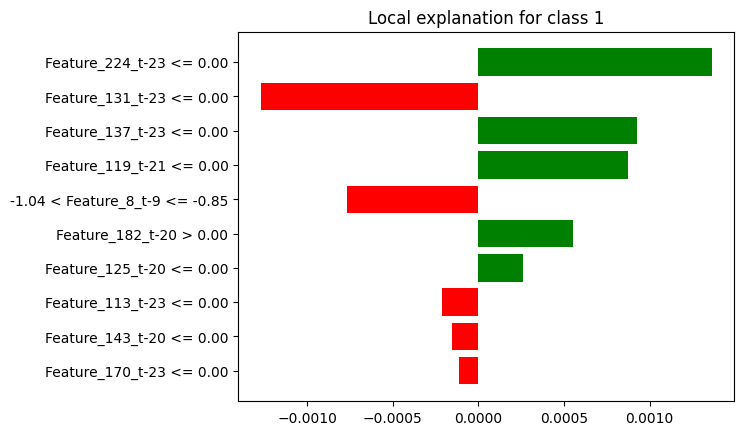

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
lime_explanation.as_pyplot_figure()
plt.show()